In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class ChebyshevKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(ChebyshevKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree

        self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.xavier_normal_(self.cheby_coeffs)
        self.register_buffer("arange", torch.arange(0, degree + 1, 1))

    def chebyshev_polynomials(self, x):
        T = [torch.ones_like(x), 2*x]
        for n in range(2, self.degree + 1):
            T.append(2 * x * T[n - 1] - T[n - 2])
        return torch.stack(T, dim=-1)

    def forward(self, x):
        x = x.view(-1, self.inputdim)
        x = torch.tanh(x)
        T = self.chebyshev_polynomials(x)
        y = torch.einsum("bij,ioj->bo", T, self.cheby_coeffs)
        y = y.view(-1, self.outdim)
        return y

class ChebyshevKAN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, degree):
        super(ChebyshevKAN, self).__init__()
        self.chebyshevkan1 = ChebyshevKANLayer(input_dim, hidden_dim, degree)
        self.chebyshevkan2 = ChebyshevKANLayer(hidden_dim, output_dim, degree)

    def forward(self, x):
        x = self.chebyshevkan1(x)
        x = self.chebyshevkan2(x)
        return x

In [2]:
# Define the target function
def complex_target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0.5
    mask2 = (0.5 <= x) & (x < 1.5)
    mask3 = x >= 1.5
    y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
    y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
    y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])
    y += np.sin(x**2) * np.exp(-x/3) + np.log1p(x) * np.cos(10 * np.pi * x)
    return y

# Generate training data
np.random.seed(0)
x_train = np.random.uniform(0, 2, 10000)
y_train = complex_target_function(x_train)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

Epoch 1/2000, Loss: 1.9307
Epoch 101/2000, Loss: 0.0096
Epoch 201/2000, Loss: 0.0044
Epoch 301/2000, Loss: 0.0086
Epoch 401/2000, Loss: 0.0040
Epoch 501/2000, Loss: 0.0038
Epoch 601/2000, Loss: 0.0036
Epoch 701/2000, Loss: 0.0032
Epoch 801/2000, Loss: 0.0084
Epoch 901/2000, Loss: 0.0029
Epoch 1001/2000, Loss: 0.0037
Epoch 1101/2000, Loss: 0.0028
Epoch 1201/2000, Loss: 0.0027
Epoch 1301/2000, Loss: 0.0028
Epoch 1401/2000, Loss: 0.0026
Epoch 1501/2000, Loss: 0.0028
Epoch 1601/2000, Loss: 0.0026
Epoch 1701/2000, Loss: 0.0026
Epoch 1801/2000, Loss: 0.0034
Epoch 1901/2000, Loss: 0.0026


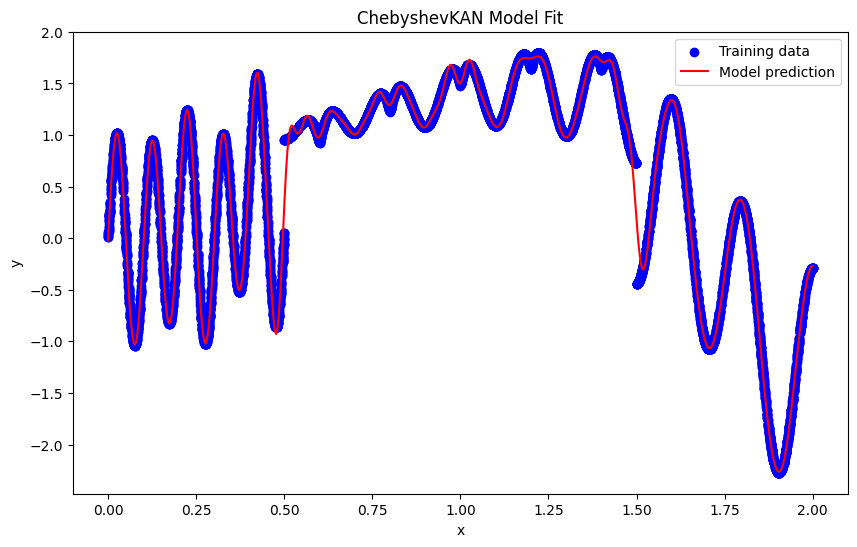

In [3]:
# Define the parameters
lr = 0.01
hidden_dim = 40
degree = 13
num_epochs = 2000

# Initialize the model
model = ChebyshevKAN(input_dim=1, hidden_dim=hidden_dim, output_dim=1, degree=degree)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# Evaluation
model.eval()
x_test = np.linspace(0, 2, 500)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)
with torch.no_grad():
    y_test_pred = model(x_test_tensor).numpy()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, color='blue', label='Training data')
plt.plot(x_test, y_test_pred, color='red', label='Model prediction')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('ChebyshevKAN Model Fit')
plt.show()